In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import os

# 1. Adjustment
Predixcan and JTI model used adjusted gene expression as:
```
The gene expression level used for training and testing was the residual of the normalized expression level after adjusting for covariates: gender, platform, first five principal components, and PEER factors for each tissue
```

In [29]:
# Adjust lipid traits:
# Take residuals of model: lipid trait ~ sex + age + PC1-5 (+ lipid lowering meds)
print('# Load INVed lipidomic data')
file_dir = '/data100t1/home/wanying/CCHC/lipidomics/input_docs/pheno_covar_files/'
fn_lip_species = 'lipid_species_INVed_covar.txt'
fn_lip_class = 'lipid_class_INVed_covar.txt'

df_lip_species = pd.read_csv(file_dir+fn_lip_species, sep='\t')
df_lip_class = pd.read_csv(file_dir+fn_lip_class, sep='\t')
# display(df_lip_species.head())

print('# Load unrelated set from PRIMUS')
fn_unrel = '/data100t1/home/wanying/CCHC/lipidomics/input_docs/primus/primus_rel_3/plink.genome_maximum_independent_set_PRIMUS'
df_unrelated = pd.read_csv(fn_unrel,sep='\t')

print('# Load ID mapping')
fn_id_mapping = '/data100t1/home/wanying/CCHC/doc/samples_IDs/202211_merged_RNA_lipid_protein_genotype_mapping_and_availability.txt'
df_id_mapping = pd.read_csv(fn_id_mapping, sep='\t')

df_unrelated = df_unrelated.merge(df_id_mapping,
                                  left_on='FID',
                                  right_on='genotype_ID').drop_duplicates(subset='RRID')

print('# ########### Run linear model ###########')
output = '/data100t1/home/wanying/CCHC/lipidomics/prediction_models/input_docs/lipid_traits_residuals/train/lipid_species_residuals_adj_for_sex_age_pc1-5.txt'
# output = '/data100t1/home/wanying/CCHC/lipidomics/prediction_models/input_docs/lipid_traits_residuals/train/lipid_species_residuals_adj_for_sex_age_statin_pc1-5.txt'
if os.path.isfile(output):
    print('# - File already exist, skip saving')
    print(f'# Done')
else:
    print(f'# - Save result to {output}')
    fh_output = open(output, 'w')
    c = 0
    df_lip_species = df_unrelated[['RRID']].merge(df_lip_species, on='RRID')
    df_lip_species['ON_STATIN'] = df_lip_species['ON_STATIN'].replace(np.nan, 0)
    # Write header line
    header = '\t'.join([x for x in df_lip_species['LABID']])
    fh_output.write('Lipid\t'+header+'\n')
    for lip in df_lip_species.columns[32:]:
        # print('# Processing:', lip)
        cov_cols = ['GENDER', 'AGE_AT_VISIT', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5']
        # cov_cols = ['GENDER', 'AGE_AT_VISIT', 'ON_STATIN', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5']
        X = df_lip_species[cov_cols]
        y = df_lip_species[lip]
        # Run OLS regression, get residuals
        reg = LinearRegression().fit(X,y)
        residuals = reg.predict(X) - y
        output_line = '\t'.join(str(val) for val in residuals)
        fh_output.write(lip+'\t'+output_line+'\n')
        c += 1
        if c%20==0:
            print('.', end='', flush=True)
    fh_output.close()
    print('# - Reformat residual file (for training purpose)')
    df_residuals = pd.read_csv(output, sep='\t').T.reset_index()
    df_residuals.columns = df_residuals.iloc[0, :].values
    df_residuals.drop(index=0, inplace=True)
    df_residuals.rename(columns={'Lipid':'Sample ID'}, inplace=True)
    df_residuals.to_csv(output+'.reformatted', sep='\t', index=False)
    print(f'# Done. {c} lipids processed')

# Load INVed lipidomic data
# Load unrelated set from PRIMUS
# Load ID mapping
# ########### Run linear model ###########
# - Save result to /data100t1/home/wanying/CCHC/lipidomics/prediction_models/input_docs/lipid_traits_residuals/train/lipid_species_residuals_adj_for_sex_age_pc1-5.txt
.........................................# - Reformat residual file (for training purpose)
# Done. 830 lipids processed


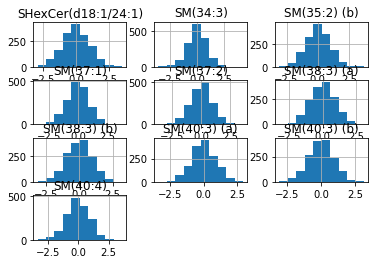

In [43]:
# Check normality of residuals (randomly pick 9 lipids)
# Look fine!
for col in df_residuals.columns[1:]:
    df_residuals[col] = pd.to_numeric(df_residuals[col], errors='coerce')
    
fig = df_residuals.iloc[:, 110:120].hist()